# DTSA 5511 Week 3 CNN Cancer Detection Kaggle Mini-Project

# Objective 

The objective of this project is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans

# Data 

In this dataset, we are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. We are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

In [1]:
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
import os
import seaborn
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import zipfile
from PIL import Image
import pickle
import sys
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [2]:
train_labels_df = pd.read_csv("train_labels.csv")
train_labels_df

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [3]:
## Function that loads data from the filesystem in the form of file location

def load_tif_images_to_dataframe(directory):
    image_data = []
    for filename in os.listdir(directory):
        if filename.endswith(".tif"):
            filepath = os.path.join(directory, filename)
        try:
            img = Image.open(filepath)
            image_data.append({'filepath': filepath})
            img.close()
        except Exception as e:
            pass
            print(f"Error loading image {filename}: {e}")
    return pd.DataFrame(image_data)

In [4]:
train_df = load_tif_images_to_dataframe("train")
train_df

,filepath
0,train/f0c2a0b8ef3024f407fa97d852d49be0215cafe0...
1,train/99ef485f205645918613cd04281098daa7c17819...
2,train/e2612e173abd0e8bb54a3c3db3f264b63d80bffb...
3,train/6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0...
4,train/9c043ab2adadfeb758c71d21432fccd3e43565c0...
...,...
220020,train/7a5f23a002018cd828cc5e8df89de79850d01050...
220021,train/7cd369c04a37c9da20bbfe1bcba2cfad754fc100...
220022,train/b21c0dc5ba97639f3b5c62ffe00364cfb0c11b40...
220023,train/d16dbdaf3b5cea4b5f6629e2a487f0e01075ba58...


In [5]:
train_df['id'] = train_df['filepath'].apply(lambda x: os.path.basename(x).split('.')[0])
train_df = train_df[train_df['id'] != '_labels']
train_df

,filepath,id
0,train/f0c2a0b8ef3024f407fa97d852d49be0215cafe0...,f0c2a0b8ef3024f407fa97d852d49be0215cafe0
1,train/99ef485f205645918613cd04281098daa7c17819...,99ef485f205645918613cd04281098daa7c17819
2,train/e2612e173abd0e8bb54a3c3db3f264b63d80bffb...,e2612e173abd0e8bb54a3c3db3f264b63d80bffb
3,train/6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0...,6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0
4,train/9c043ab2adadfeb758c71d21432fccd3e43565c0...,9c043ab2adadfeb758c71d21432fccd3e43565c0
...,...,...
220020,train/7a5f23a002018cd828cc5e8df89de79850d01050...,7a5f23a002018cd828cc5e8df89de79850d01050
220021,train/7cd369c04a37c9da20bbfe1bcba2cfad754fc100...,7cd369c04a37c9da20bbfe1bcba2cfad754fc100
220022,train/b21c0dc5ba97639f3b5c62ffe00364cfb0c11b40...,b21c0dc5ba97639f3b5c62ffe00364cfb0c11b40
220023,train/d16dbdaf3b5cea4b5f6629e2a487f0e01075ba58...,d16dbdaf3b5cea4b5f6629e2a487f0e01075ba58


In [6]:
train_data_df = pd.merge(train_df, train_labels_df, on='id').drop(columns = ['id'])
train_df = None # Resetting for system memory
train_labels_df = None # Resetting for system memory
print(Counter(train_data_df.label))
print(train_data_df.info())
train_data_df

Counter({0: 130908, 1: 89117})
<class 'pandas.core.frame.DataFrame'>
Int64Index: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filepath  220025 non-null  object
 1   label     220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.0+ MB
None


,filepath,label
0,train/f0c2a0b8ef3024f407fa97d852d49be0215cafe0...,0
1,train/99ef485f205645918613cd04281098daa7c17819...,1
2,train/e2612e173abd0e8bb54a3c3db3f264b63d80bffb...,1
3,train/6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0...,0
4,train/9c043ab2adadfeb758c71d21432fccd3e43565c0...,1
...,...,...
220020,train/7a5f23a002018cd828cc5e8df89de79850d01050...,1
220021,train/7cd369c04a37c9da20bbfe1bcba2cfad754fc100...,1
220022,train/b21c0dc5ba97639f3b5c62ffe00364cfb0c11b40...,0
220023,train/d16dbdaf3b5cea4b5f6629e2a487f0e01075ba58...,0


# Exploratory Data Analysis 

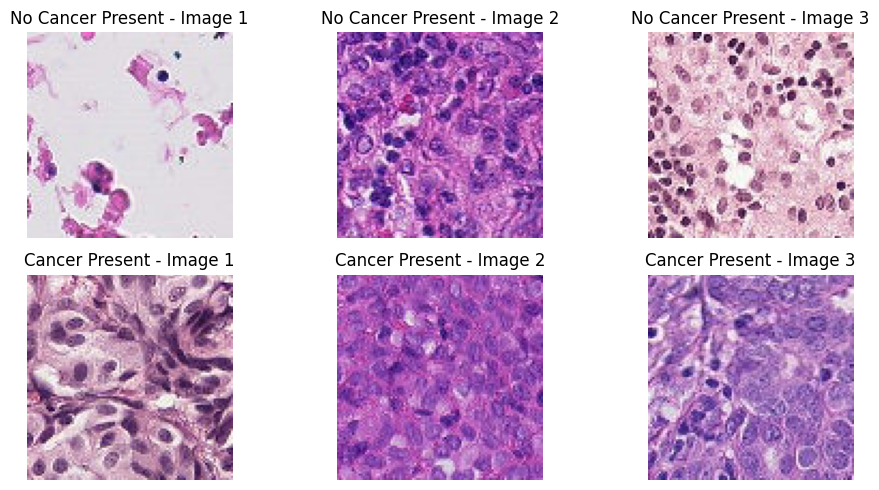

In [7]:
## Display images of each class

label_0 = train_data_df[train_data_df['label'] == 0][0:3]
label_1 = train_data_df[train_data_df['label'] == 1][0:3]

plt.figure(figsize=(10, 5))

for i in range(3):
    # Label 0 images
    img_path = label_0.iloc[i]['filepath']
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f'No Cancer Present - Image {i+1}')
    plt.axis('off')

for i in range(3):
    # Label 1 images
    img_path = label_1.iloc[i]['filepath']
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 4)
    plt.imshow(img)
    plt.title(f'Cancer Present - Image {i+1}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

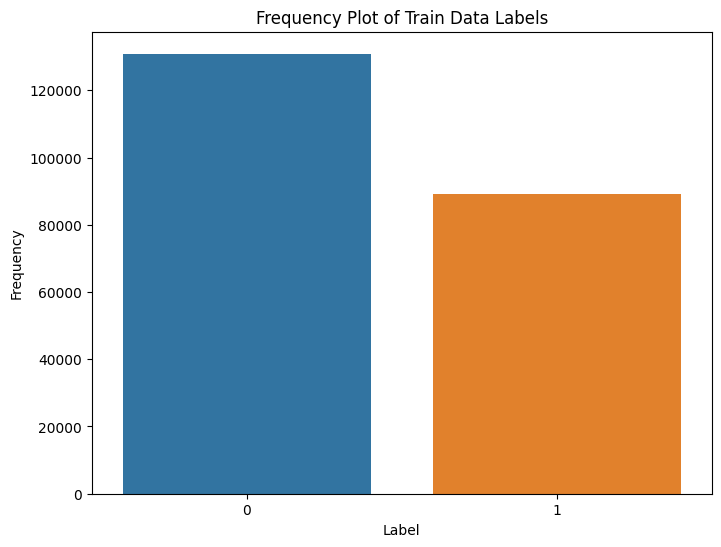

In [8]:
## Display a frequency plot of the train data label distribution

label_counts = train_data_df['label'].value_counts()
plt.figure(figsize=(8, 6))
seaborn.countplot(x='label', data=train_data_df)
plt.title('Frequency Plot of Train Data Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

From the plot above we see that there are ~130,000+ non cancer images and ~90,000 cancerous images. 

# Setup and Train Model 

In [9]:
## Setup the train and validation data for model development

train_df, validation_df = train_test_split(train_data_df, test_size = 0.3, random_state = 0)
train_data_df = None # Reseting for memory

In [10]:
validation_df


,filepath,label
155115,train/e3424e29c515bc20ae7fdd84b742aadd0f14838b...,0
145742,train/0c8492c5ab94a2a011452d34c6019ba691b40b69...,0
105400,train/cc1191e93b9c344bd12cb240e1122622081d3079...,0
61543,train/5bf7dbaddc83ab08f162d451a63470acb2baff5b...,0
32978,train/74e8d06b196e97b94aab93207681b34f4a3cba6f...,0
...,...,...
180112,train/2c8dd8ef25e1ef661115742b8b4977f52741003f...,1
192655,train/c30795e221aa96b940cc5d795ceaebeead95d5cf...,1
124067,train/0c29b70885ed002397d2bae068e2fbb55c3b8b89...,0
122609,train/cf8076828ab540a9f46f8e2a94fbad0689abd593...,1


In [11]:
## Setup data for ImageDataGenerator and flow_from_dataframe

train_df['label'] = train_df['label'].astype(str)
validation_df['label'] = validation_df['label'].astype(str)

In [12]:
## Obtain image dimensions

image = Image.open(train_df.iloc[0]['filepath'])
width, height = image.size
batch_size = 64
img_size = (width, height)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
print("Image shape:", img_shape)

Image shape: (96, 96, 3)


In [13]:
## Transform the train and validation data for use by keras

train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath',
    y_col = 'label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'binary')
train_df = None # Reset for memory

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col = 'filepath',
    y_col = 'label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode= 'binary')
validation_df = None # Reset for memory

Found 154017 validated image filenames belonging to 2 classes.
Found 66008 validated image filenames belonging to 2 classes.


In [14]:
## Setup test data, only file paths needed for now as the images will be loaded later for prediction

def load_filepaths(directory):
    file_paths = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        file_paths.append(filepath)
    test_data_prepared = pd.DataFrame({'file_paths': file_paths})
    file_paths = None
    return test_data_prepared

test_data_prepared = load_filepaths("test")
test_data_prepared

,file_paths
0,test/fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif
1,test/1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif
2,test/19709bec800f372d0b1d085da6933dd3ef108846.tif
3,test/7a34fc34523063f13f0617f7518a0330f6187bd3.tif
4,test/93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif
...,...
57453,test/2581931c6ef068f105a872f2c5500275fc678242.tif
57454,test/11b250a664d09ab59fd2afbdb2f8d786763b185d.tif
57455,test/18a6030935ec1ef1ce486ec51bc95abb4008fbf1.tif
57456,test/f541404e501e23a0188c852eb37eac94053cfdc0.tif


# Max Pooling Model 


We are going to use a max pooling model. Max pooling is a feature extraction technique used in convolutional neural networks (CNNs) to reduce the spatial dimensions of an input image. It works by dividing an image into non-overlapping regions and selecting the maximum value from each region. The result is a downsampled image that contains the most important information while discarding less important details

In [15]:
## Create a CNN using max pooling layers

model_max_pooling = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_max_pooling.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_max_pooling = model_max_pooling.fit(
    train_generator,
    epochs=8,
    validation_data=validation_generator
)

loss_max_pooling, accuracy_max_pooling = model_max_pooling.evaluate(validation_generator)
print(f"Validation Loss: {loss_max_pooling}")
print(f"Validation Accuracy: {accuracy_max_pooling}")

model_max_pooling.save('models/model_max_pooling.keras')

Epoch 1/8


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2407/2407 ━━━━━━━━━━━━━━━━━━━━ 193s 80ms/step - accuracy: 0.6757 - loss: 0.5611 - val_accuracy: 0.8148 - val_loss: 0.4163
Epoch 2/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 196s 81ms/step - accuracy: 0.8256 - loss: 0.3935 - val_accuracy: 0.8373 - val_loss: 0.3726
Epoch 3/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 192s 80ms/step - accuracy: 0.8488 - loss: 0.3493 - val_accuracy: 0.8524 - val_loss: 0.3442
Epoch 4/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 193s 80ms/step - accuracy: 0.8745 - loss: 0.2980 - val_accuracy: 0.8581 - val_loss: 0.3362
Epoch 5/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 192s 80ms/step - accuracy: 0.8972 - loss: 0.2498 - val_accuracy: 0.8622 - val_loss: 0.3318
Epoch 6/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 192s 80ms/step - accuracy: 0.9205 - loss: 0.1988 - val_accuracy: 0.8574 - val_loss: 0.3763
Epoch 7/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 193s 80ms/step - accuracy: 0.9424 - loss: 0.1503 - val_accuracy: 0.8547 - val_loss: 0.3965
Epoch 8/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 192s 80ms/step - accuracy: 0.9614 - loss: 0.1

In [25]:
model_max_pooling = keras.models.load_model('models/model_max_pooling.keras')
predictions = []
with open(os.devnull, 'w') as devnull:
    old_stdout = sys.stdout
    sys.stdout = devnull
    try:
        # Iterate over test image filepaths
        for filepath in test_data_prepared.file_paths:
            # Load and preprocess the image
            img = Image.open(filepath)
            img = img.resize(img.size) # Assuming img_size is defined from previous code
            img_array = np.array(img) / 255.0 # Normalize pixel values
            img.close()
            img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
            prediction = model_max_pooling.predict(img_array)
            predictions.append(prediction[0][0])
        results = pd.DataFrame({'id': test_data_prepared.file_paths, 'label': predictions})
        results['label'] = results['label'].round()
        results['id'] = results['id'].apply(lambda x: os.path.basename(x).split('.')[0])
    finally:
        sys.stdout = old_stdout
model_max_pooling = None
results.to_csv('results/model_max_pooling_results.csv', index=False)  

# Max Pooling - Visualize Results 

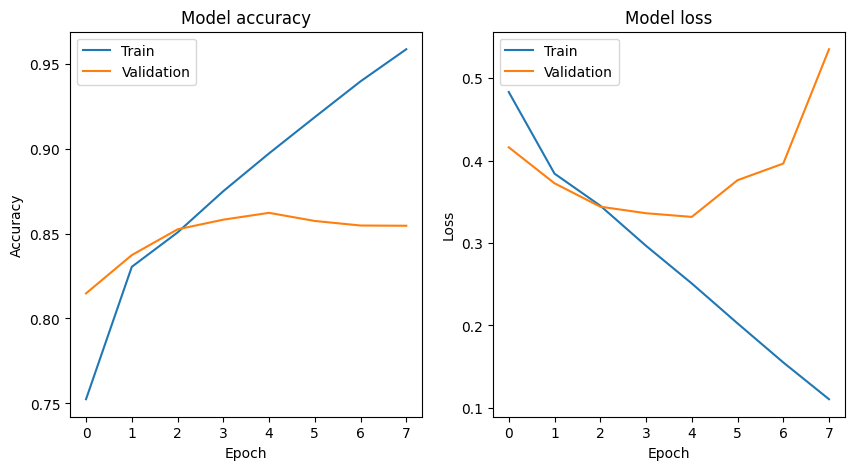

In [17]:
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_max_pooling.history['accuracy'])
plt.plot(history_max_pooling.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_max_pooling.history['loss'])
plt.plot(history_max_pooling.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# plt.tight_layout()
plt.show()

# Max Pooling - Classification Report and Confusion Matrix 

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step
              precision    recall  f1-score   support

           0       0.60      0.59      0.59     39345
           1       0.40      0.40      0.40     26663

    accuracy                           0.52     66008
   macro avg       0.50      0.50      0.50     66008
weighted avg       0.52      0.52      0.52     66008



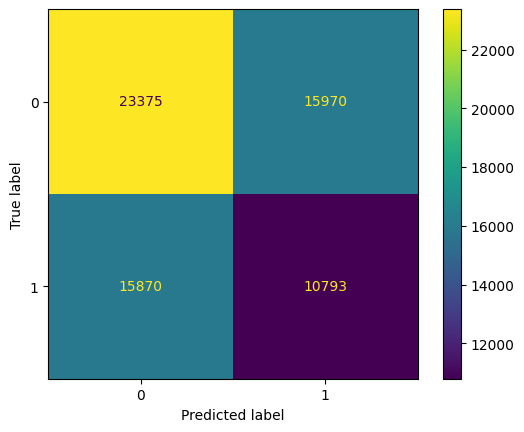

In [18]:
## Generate a classification report and confusion matrix for the validation predictions

validation_predictions = model_max_pooling.predict(validation_generator)
validation_pred_labels = (validation_predictions > 0.5).astype(int)

# Get true labels
validation_true_labels = validation_generator.classes

# Generate classification report
class_report = classification_report(validation_true_labels, validation_pred_labels)
print(class_report)

# Generate confusion matrix
cm = confusion_matrix(validation_true_labels, validation_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1'])
disp.plot()
plt.show()

# Average Pooling Model

Average pooling is a technique used in convolutional neural networks (CNNs) to reduce the size of feature maps while keeping important information. It works by calculating the average value of a region in the feature map, and then using that value to create a downsampled feature map

In [20]:
## Create a CNN model using average pooling layers

model_average_pooling = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
    layers.AveragePooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.AveragePooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_average_pooling.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_avg_pooling = model_average_pooling.fit(
    train_generator,
    epochs=8,
    validation_data=validation_generator
)

loss_avg_pooling, accuracy_avg_pooling = model_average_pooling.evaluate(validation_generator)
print(f"Validation Loss: {loss_avg_pooling}")
print(f"Validation Accuracy: {accuracy_avg_pooling}")

model_average_pooling.save('models/model_average_pooling.keras')

Epoch 1/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 193s 80ms/step - accuracy: 0.7417 - loss: 0.5291 - val_accuracy: 0.8147 - val_loss: 0.4175
Epoch 2/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 189s 79ms/step - accuracy: 0.8161 - loss: 0.4128 - val_accuracy: 0.8365 - val_loss: 0.3736
Epoch 3/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 189s 79ms/step - accuracy: 0.8377 - loss: 0.3707 - val_accuracy: 0.8379 - val_loss: 0.3657
Epoch 4/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 190s 79ms/step - accuracy: 0.8522 - loss: 0.3409 - val_accuracy: 0.8381 - val_loss: 0.3673
Epoch 5/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 191s 79ms/step - accuracy: 0.8668 - loss: 0.3117 - val_accuracy: 0.8507 - val_loss: 0.3432
Epoch 6/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 191s 79ms/step - accuracy: 0.8795 - loss: 0.2851 - val_accuracy: 0.8518 - val_loss: 0.3444
Epoch 7/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 191s 79ms/step - accuracy: 0.8968 - loss: 0.2496 - val_accuracy: 0.8457 - val_loss: 0.3574
Epoch 8/8
2407/2407 ━━━━━━━━━━━━━━━━━━━━ 191s 79ms/step - accuracy: 0.9106 -

In [24]:
model_average_pooling = keras.models.load_model('models/model_average_pooling.keras')
predictions = []
with open(os.devnull, 'w') as devnull:
    old_stdout = sys.stdout
    sys.stdout = devnull
    try:
        # Iterate over test image filepaths
        for filepath in test_data_prepared.file_paths:
            # Load and preprocess the image
            img = Image.open(filepath)
            img = img.resize(img.size) # Assuming img_size is defined from previous code
            img_array = np.array(img) / 255.0 # Normalize pixel values
            img.close()
            img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
            prediction = model_average_pooling.predict(img_array)
            predictions.append(prediction[0][0])
        results = pd.DataFrame({'id': test_data_prepared.file_paths, 'label': predictions})
        results['label'] = results['label'].round()
        results['id'] = results['id'].apply(lambda x: os.path.basename(x).split('.')[0])
    finally:
        sys.stdout = old_stdout
model_average_pooling = None
results.to_csv('results/model_average_pooling_results.csv', index=False)   

# Average Pooling - Visualize Results 

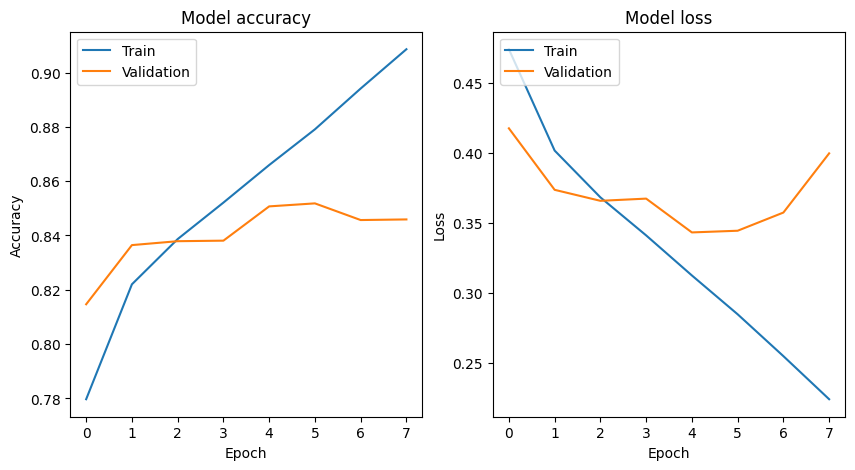

In [21]:
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_avg_pooling.history['accuracy'])
plt.plot(history_avg_pooling.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_avg_pooling.history['loss'])
plt.plot(history_avg_pooling.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# plt.tight_layout()
plt.show()

# Average Pooling - Classification Report and Confusion Matrix

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step
              precision    recall  f1-score   support

           0       0.60      0.67      0.63     39345
           1       0.40      0.33      0.36     26663

    accuracy                           0.53     66008
   macro avg       0.50      0.50      0.50     66008
weighted avg       0.52      0.53      0.52     66008



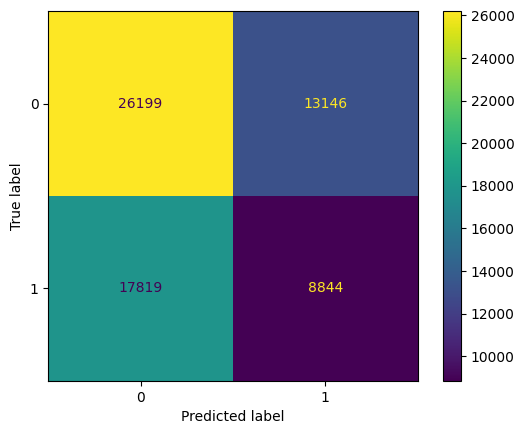

In [22]:
## Generate a classification report and confusion matrix for the validation predictions

validation_predictions = model_average_pooling.predict(validation_generator)
validation_pred_labels = (validation_predictions > 0.5).astype(int)

# Get true labels
validation_true_labels = validation_generator.classes

# Generate classification report
class_report = classification_report(validation_true_labels, validation_pred_labels)
print(class_report)

# Generate confusion matrix
cm = confusion_matrix(validation_true_labels, validation_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1'])
disp.plot()
plt.show()

# Conclusion

The main takeaway regarding model selection indicates that using specialized max and average pooling layers results in the best scores, with the best model I created resulting in a Kaggle score of 82. 

While the max pooling model resulted in a slightly higher accuracy, the average pooling model had less validation loss. 

These models exhibit significantly longer training times compared to a baseline model. Training duration is influenced by several hyperparameters, including the number of epochs and network architecture (number of layers and neurons per layer). Increasing network complexity (e.g., adding layers or increasing neuron counts) expands the model's parameter space, raising the risk of overfitting and necessitating adjustments to the epoch count.

Future improvements warrant exploration of several avenues. Increasing the number of layers and experimenting with diverse layer types could enhance performance. Furthermore, feature engineering techniques, such as data augmentation, could augment the training dataset, potentially mitigating class imbalance and improving generalization to the Kaggle test set. Finally, optimization of hyperparameters, including the loss function and optimizer, should be investigated using the established model architectures.